In [ ]:
#Importing data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH='/content/drive/MyDrive/velozity/'  

In [ ]:
!pip install wfdb &> /dev/null
!pip install tqdm
!pip install biosppy
!pip install matplotlib==3.1.3 &> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 37.5 MB/s 


In [ ]:
!pip install pyedflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 29.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import os
import warnings
warnings.filterwarnings('ignore')

import wfdb as wf
import pyedflib

from scipy import signal
from biosppy.signals import ecg

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Activation, Add, Softmax
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

In [ ]:
data = pd.read_csv(DATA_PATH + 'mitbih_train.csv',header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


Text(0.5, 1.0, '0.0')

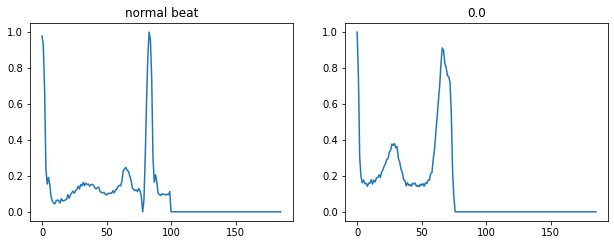

In [ ]:
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(data.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(data.iloc[8310,:186])
plt.title(data.iloc[8310,187])

In [ ]:
data[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [ ]:
class_1 = data[data[187]==1.0]
class_2 = data[data[187]==2.0]
class_3 = data[data[187]==3.0]
class_4 = data[data[187]==4.0]
class_0 = data[data[187]==0.0].sample(n = 8000)
data = pd.concat([class_1, class_2, class_3, class_4, class_0]).sample(frac=1)

In [ ]:
data[187].value_counts()

0.0    8000
4.0    6431
2.0    5788
1.0    2223
3.0     641
Name: 187, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the dataset 
xtrain, xtest, ytrain, ytest = train_test_split(data.drop([187], axis=1), data[187], test_size = 0.1)

In [ ]:
xtrain = np.array(xtrain).reshape(xtrain.shape[0], xtrain.shape[1], 1)
xtest = np.array(xtest).reshape(xtest.shape[0], xtest.shape[1], 1)

In [ ]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation='relu', input_shape = (xtrain.shape[1],1)))
model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation='relu')) 
model.add(Conv1D(filters=128, kernel_size=(5,), padding='same', activation='relu')) 
model.add(Conv1D(filters=256, kernel_size=(5,), padding='same', activation='relu'))    

model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = 1024, activation='relu'))
model.add(Dense(units = 5, activation='softmax'))

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fitted_model = model.fit(xtrain, ytrain, epochs = 10)

Epoch 1/10
650/650 [==============================] - 20s 11ms/step - loss: 0.3832 - accuracy: 0.8651
Epoch 2/10
650/650 [==============================] - 6s 8ms/step - loss: 0.1989 - accuracy: 0.9345
Epoch 3/10
650/650 [==============================] - 6s 9ms/step - loss: 0.1485 - accuracy: 0.9491
Epoch 4/10
650/650 [==============================] - 6s 9ms/step - loss: 0.1177 - accuracy: 0.9595
Epoch 5/10
650/650 [==============================] - 6s 8ms/step - loss: 0.0975 - accuracy: 0.9669
Epoch 6/10
650/650 [==============================] - 6s 8ms/step - loss: 0.0811 - accuracy: 0.9708
Epoch 7/10
650/650 [==============================] - 6s 9ms/step - loss: 0.0756 - accuracy: 0.9727
Epoch 8/10
650/650 [==============================] - 6s 9ms/step - loss: 0.0560 - accuracy: 0.9796
Epoch 9/10
650/650 [==============================] - 6s 9ms/step - loss: 0.0555 - accuracy: 0.9801
Epoch 10/10
650/650 [==============================] - 6s 9ms/step - loss: 0.0474 - accuracy: 0.98

In [ ]:
ypred = model.predict(xtest)

73/73 [==============================] - 0s 5ms/step


In [ ]:
ypred

array([[9.1735840e-01, 4.5592319e-03, 7.2085863e-06, 7.8073680e-02,
        1.4685776e-06],
       [6.4976713e-13, 8.0360105e-19, 3.5060541e-20, 2.0080961e-27,
        1.0000000e+00],
       [9.2852218e-15, 3.2198216e-13, 1.0000000e+00, 3.5510184e-12,
        1.3018718e-12],
       ...,
       [4.9428490e-07, 5.7171019e-09, 9.9999738e-01, 1.1292819e-10,
        2.1289493e-06],
       [9.1679376e-01, 2.0534021e-03, 7.7941105e-02, 1.8546721e-03,
        1.3569525e-03],
       [9.9928445e-01, 6.6860468e-04, 2.2840523e-09, 2.3528003e-06,
        4.4582888e-05]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

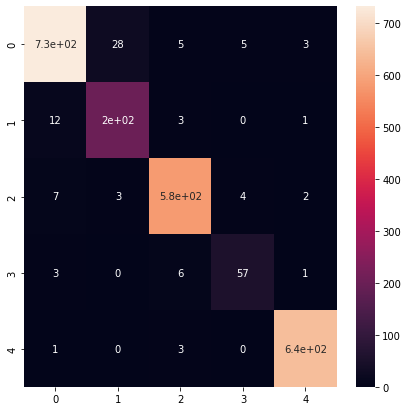

In [ ]:
y = [np.where(i == np.max(i))[0][0] for i in ypred]
mat = confusion_matrix(ytest, y)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(mat, annot = True)

In [ ]:
print("Accuracy score of the predictions: {0}".format(accuracy_score(y, ytest)))

Accuracy score of the predictions: 0.9623213512343005


**Predicting from an edf file**

In [ ]:
f = pyedflib.EdfReader(DATA_PATH + "10-12-27.EDF")

In [ ]:
print(f)

In [ ]:
signal_labels = f.getSignalLabels() 
sigbufs = np.zeros((1, f.getNSamples()[0]))
for i in np.arange(1):
    sigbufs[i, :] = f.readSignal(i)   # Numpy array of the signal values

In [ ]:
print(sigbufs)
print(sigbufs.shape)
print(signal_labels)

[[   0.   24.   45. ...  -93. -115. -134.]]
(1, 68678375)
['ECG', 'Marker']


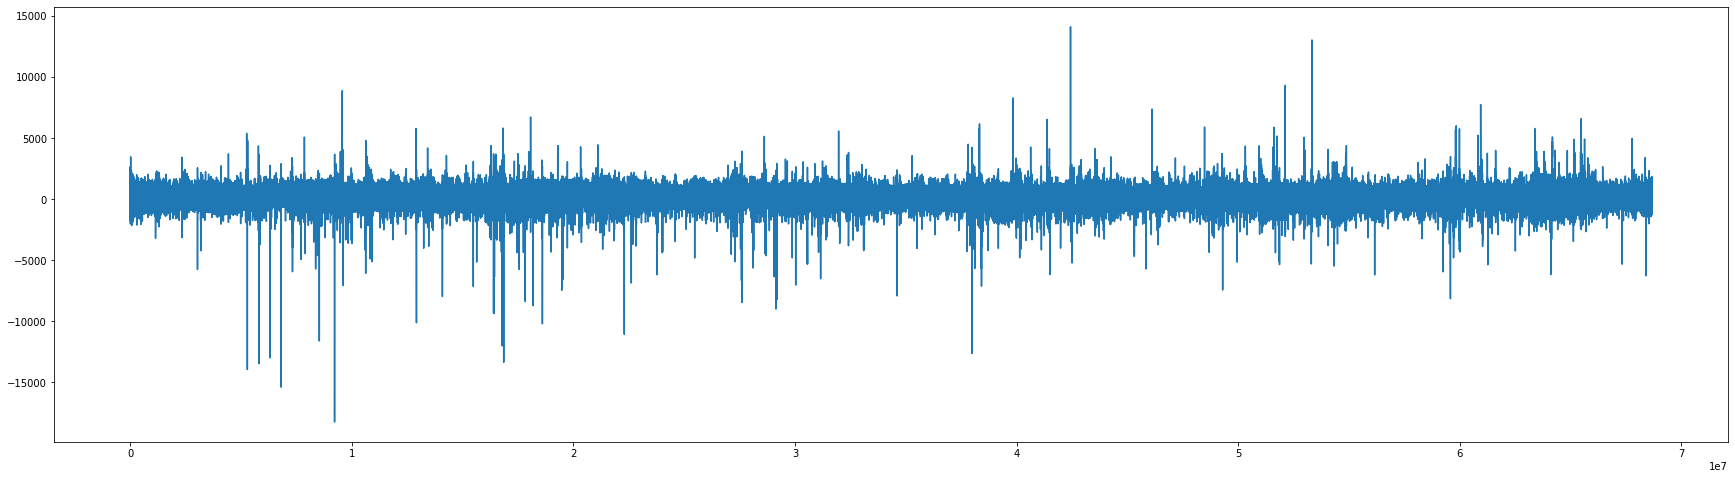

In [ ]:
plt.figure(figsize=(30,8))
#fig = plt.figure()
ax = plt.axes()
for i in np.arange(1):
  ax.plot(f.readSignal(i))
plt.show()

In [ ]:
print(f.readSignal(0).shape)
print(type(f.readSignal(0)))
print(f.getSampleFrequency(0))

(68678375,)
<class 'numpy.ndarray'>
125.0


In [ ]:
data = sigbufs
data = data[0,0:40000]
#data = data[0]
data = data.reshape(1,len(data))
print(data,"\n", data.shape)

[[   0.   24.   45. ... -410. -484. -592.]] 
 (1, 40000)


In [ ]:
for channelid, channel in enumerate(data):

        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        print("Rpeaks: ", rpeaks)

        beatstoremove = np.array([0])
        beats = np.split(channel, out['rpeaks'])

        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], 0)

Rpeaks:  [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(len(beats), type(beats))
for i in range(10):
  print(len(beats[i]), end=" ")

312 <class 'list'>
212 188 188 188 188 188 188 188 188 188 

In [ ]:
print(len(beatstoremove), type(beatstoremove))
print(beatstoremove.shape)
print(beatstoremove)

1 <class 'numpy.ndarray'>
(1,)
[0]


In [ ]:
beatstoremove = np.append(beatstoremove, len(beats)-1) #Removing unnecessary beats

# Remove first and last beats and the ones without classification.
beats = np.delete(beats, beatstoremove)

In [ ]:
savedata = np.array(list(beats[:]), dtype=np.float)
outfn = DATA_PATH + 'SampleECG' +'.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

Generating  /content/drive/MyDrive/velozity/SampleECG.csv


In [ ]:
import pandas as pd

temp_df = pd.read_csv(DATA_PATH + 'SampleECG.csv', header=None)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.835591,0.582913,0.283711,0.100614,0.191445,0.417653,0.508231,0.509257,0.544151,0.551948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.836627,0.685339,0.364871,0.161041,0.197243,0.438128,0.526883,0.543419,0.529010,0.511581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.540616,0.318634,0.123649,0.005064,0.098388,0.261648,0.303558,0.297008,0.302816,0.318593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.819559,0.691087,0.290314,0.291852,0.250639,0.275365,0.230091,0.230027,0.202066,0.200728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.795307,0.638503,0.323387,0.159662,0.314495,0.518204,0.528231,0.526996,0.584367,0.587264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp_df.iloc[0,40]

0.629021

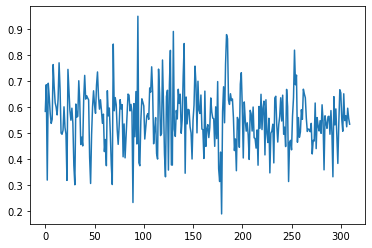

In [ ]:
plt.plot(temp_df[1])

In [ ]:
x=temp_df.iloc[:,:187]
y=temp_df.iloc[:,187]

In [ ]:
x = np.array(x).reshape(x.shape[0], x.shape[1], 1)
prediction = model.predict(x)

10/10 [==============================] - 0s 23ms/step


In [ ]:
prediction

array([[9.8882931e-01, 5.9034964e-03, 5.0635779e-05, 9.8972869e-06,
        5.2065444e-03],
       [1.0000000e+00, 3.6425167e-08, 3.9312191e-08, 1.1977735e-10,
        1.0637345e-09],
       [6.6619956e-01, 5.9354785e-03, 3.2348621e-01, 4.2417315e-03,
        1.3698824e-04],
       ...,
       [9.9737751e-01, 2.1154901e-03, 1.7639823e-04, 3.2787217e-04,
        2.7336962e-06],
       [1.0000000e+00, 4.3491315e-08, 3.4814956e-10, 3.6574668e-10,
        8.1007739e-10],
       [9.8559004e-01, 2.6055183e-03, 8.8724289e-03, 2.8967324e-03,
        3.5417306e-05]], dtype=float32)

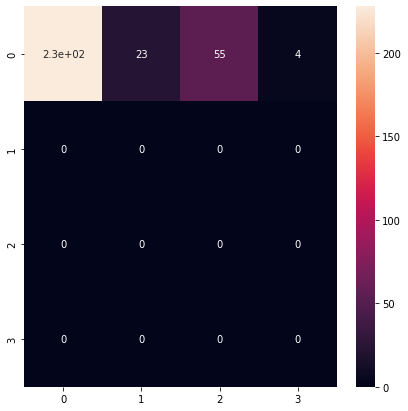

In [ ]:
a = [np.where(i == np.max(i))[0][0] for i in prediction]
mat = confusion_matrix(y, a)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(mat, annot = True)

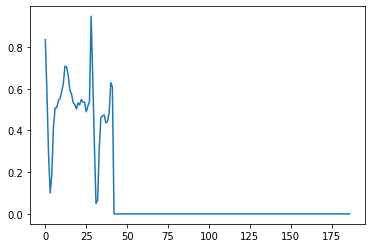

In [ ]:
plt.plot(x[0])

Text(0.5, 1.0, 'abnormal beat')

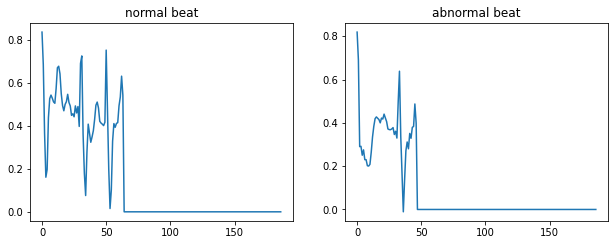

In [ ]:
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(x[1])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(x[3])
plt.title('abnormal beat')